## 1. Retrieve Slice
For initial stages, using CreateSlice.ipynb from `/teaching-materials/teaching-materials/assignments/Exploring Queues`

In [1]:
# Load Fablib and Node Information
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
fablib.show_config()
import json
import traceback
import time

slice_name = "ECE6400-Final-DDoS-Sim"
slice = fablib.get_slice(slice_name)
slice.list_nodes()


Orchestrator,orchestrator.fabric-testbed.net
Credential Manager,cm.fabric-testbed.net
Core API,uis.fabric-testbed.net
Artifact Manager,artifacts.fabric-testbed.net
Token File,/home/fabric/.tokens.json
Project ID,0508639f-d515-44c8-b922-cf4cf000b6d9
Bastion Host,bastion.fabric-testbed.net
Bastion Username,aorourk_0000288214
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Slice Private Key File,/home/fabric/work/fabric_config/slice_key


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
74818f35-406a-4919-af4f-820036ca1146,Bot_0,1,2,10,default_ubuntu_20,qcow2,eduky-w3.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fecb:b108,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fecb:b108,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
1312dd26-f23d-4a38-b294-92871d09c498,Bot_1,1,2,10,default_ubuntu_20,qcow2,eduky-w14.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe8b:98a,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe8b:98a,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
c3cb7de8-bd9d-4903-baf7-9705ed684c40,Bot_2,1,2,10,default_ubuntu_20,qcow2,eduky-w10.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe8d:a8b2,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe8d:a8b2,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
37c40acd-0607-422a-85a1-23248ce0944b,Bot_3,1,2,10,default_ubuntu_20,qcow2,eduky-w6.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fecd:152a,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fecd:152a,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
6dd4b737-0980-48ab-b93f-ae6b6ab0f067,Controller,1,2,10,default_ubuntu_20,qcow2,eduky-w1.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe25:538b,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe25:538b,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
2069a99c-ef93-42e9-a140-70a62eaf81f3,Target,1,2,10,default_ubuntu_20,qcow2,eduky-w12.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe68:15c,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe68:15c,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
caa535d1-0d01-4017-8b23-c8c0599b4edb,User,1,2,10,default_ubuntu_20,qcow2,eduky-w9.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fef1:de1b,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fef1:de1b,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
74818f35-406a-4919-af4f-820036ca1146,Bot_0,1,2,10,default_ubuntu_20,qcow2,eduky-w3.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fecb:b108,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fecb:b108,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
1312dd26-f23d-4a38-b294-92871d09c498,Bot_1,1,2,10,default_ubuntu_20,qcow2,eduky-w14.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe8b:98a,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe8b:98a,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
c3cb7de8-bd9d-4903-baf7-9705ed684c40,Bot_2,1,2,10,default_ubuntu_20,qcow2,eduky-w10.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe8d:a8b2,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe8d:a8b2,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
37c40acd-0607-422a-85a1-23248ce0944b,Bot_3,1,2,10,default_ubuntu_20,qcow2,eduky-w6.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fecd:152a,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fecd:152a,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
6dd4b737-0980-48ab-b93f-ae6b6ab0f067,Controller,1,2,10,default_ubuntu_20,qcow2,eduky-w1.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe25:538b,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe25:538b,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
2069a99c-ef93-42e9-a140-70a62eaf81f3,Target,1,2,10,default_ubuntu_20,qcow2,eduky-w12.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe68:15c,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe68:15c,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
caa535d1-0d01-4017-8b23-c8c0599b4edb,User,1,2,10,default_ubuntu_20,qcow2,eduky-w9.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fef1:de1b,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fef1:de1b,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


### 2. Load Nodes

In [2]:
# Setup constants
nBots = 4

# Load nodes
bots = [slice.get_node(name=f"Bot_{i}") for i in range(nBots)]
target = slice.get_node(name="Target")
controller = slice.get_node(name="Controller")
user = slice.get_node(name="User")

ip_target = "10.0.0.2"


### 3. Baseline Metric Collection

In [3]:
#print("\n===== Collect Baseline Metrics =====")
#print("\n--- Baseline Latency & Packet Loss (Target -> Controller) ---")
#print(target.execute(f"ping -i 0.5 -c 20 {controller.get_management_ip()}"))

print("\n--- Baseline Latency & Packet Loss (User -> Target) ---")
output = user.execute(f"ping -i 0.2 -c 200 {ip_target}")
with open("./demo_user_results/User_ping_result_baseline.txt", "w") as f:
    f.write(output[0])

#print("\n--- Baseline Queue Status on Target ---")
#print(target.execute("sudo tc -s qdisc show dev enp7s0"))

#print("\n--- Baseline CPU Usage on Target ---")
#print(target.execute("top -bn1 | head -n 10"))

#print("\n--- Baseline Network Traffic Stats on Target ---")
#print(target.execute("ifconfig enp7s0"))

#time.sleep(2)


--- Baseline Latency & Packet Loss (User -> Target) ---
PING 10.0.0.2 (10.0.0.2) 56(84) bytes of data.
64 bytes from 10.0.0.2: icmp_seq=1 ttl=64 time=0.124 ms
64 bytes from 10.0.0.2: icmp_seq=2 ttl=64 time=0.075 ms
64 bytes from 10.0.0.2: icmp_seq=3 ttl=64 time=0.068 ms
64 bytes from 10.0.0.2: icmp_seq=4 ttl=64 time=0.066 ms
64 bytes from 10.0.0.2: icmp_seq=5 ttl=64 time=0.069 ms
64 bytes from 10.0.0.2: icmp_seq=6 ttl=64 time=0.089 ms
64 bytes from 10.0.0.2: icmp_seq=7 ttl=64 time=0.068 ms
64 bytes from 10.0.0.2: icmp_seq=8 ttl=64 time=0.064 ms
64 bytes from 10.0.0.2: icmp_seq=9 ttl=64 time=0.064 ms
64 bytes from 10.0.0.2: icmp_seq=10 ttl=64 time=0.074 ms
64 bytes from 10.0.0.2: icmp_seq=11 ttl=64 time=0.061 ms
64 bytes from 10.0.0.2: icmp_seq=12 ttl=64 time=0.067 ms
64 bytes from 10.0.0.2: icmp_seq=13 ttl=64 time=0.062 ms
64 bytes from 10.0.0.2: icmp_seq=14 ttl=64 time=0.068 ms
64 bytes from 10.0.0.2: icmp_seq=15 ttl=64 time=0.066 ms
64 bytes from 10.0.0.2: icmp_seq=16 ttl=64 time=0.

### 2. Sending instructions to the bots from the controller

In [4]:
start_time = time.time()

# Threading Functions
def start_ping_flood(bot, ip_target, params):
    try:
        bot.execute("sudo rm ping_output.txt")
        print(f"[{(time.time()-start_time):.4f} sec]\tStarting ping flood attack from {bot.get_name()}...")
        bot.execute(f"nohup sudo ping -f -c {params['num_bot_pkts']} {ip_target} > ping_output.txt 2>&1 &")
    except Exception as e:
        print(f"Error starting ping flood on {bot.get_name()}: {e}\n")

def start_user_ping(user, ip_target, params):
    try:
        user.execute("sudo rm ping_output.txt ping_pid.txt")
        print(f"[{(time.time()-start_time):.4f} sec]\tStarting ping from {user.get_name()}...")
        user.execute(f"nohup sudo ping -i {params['user_interval']} -c {params['num_user_pkts']} {ip_target} > ping_output.txt 2>&1 & echo $! > ping_pid.txt")
    except Exception as e:
        print(f"Error starting ping on {user.get_name()}: {e}\n")

def wait_for_ping_to_finish(bot):
    print(f"Waiting for {bot.get_name()} to finish ping flood...")
    while True:
        stdout, sterr = bot.execute("pgrep ping", quiet=True)
        if stdout.strip() == "":
            print(f"[{(time.time()-start_time):.4f} sec]\t{bot.get_name()} finished.")
            break
        time.sleep(2)

def wait_for_ping_to_finish_user(bot):
    print(f"Waiting for {bot.get_name()} to finish ping flood...")
    stdout, stderr = bot.execute("cat ping_pid.txt", quiet=True)
    pid = stdout.strip()
    if pid == "":
        print(f"No PID file found on {bot.get_name()}.")
        return
    while True:
        stdout, stderr = bot.execute(f"ps -p {pid}", quiet=True)
        if "ping" not in stdout:
            print(f"[{(time.time()-start_time):.4f} sec]\t{bot.get_name()} finished ping.")
            time.sleep(1)
            break
        time.sleep(2)

def collect_ping_results(bot, params):
    try:
        if (bot.get_name() == 'User'):
            bot.download_file(f"./demo_user_results/{bot.get_name()}_ping_result_{params['target_rate']}KBps_{params['target_queue']}KB.txt", "ping_output.txt")
        else:
            bot.download_file(f"./demo_bot_results/{bot.get_name()}_ping_result_{params['target_rate']}KBps_{params['target_queue']}KB.txt", "ping_output.txt")
        print(f"Saved ping result for {bot.get_name()}")
    except Exception as e:
        print(f"Error saving ping result from {bot.get_name()}: {e}")

In [5]:
import threading

# Target Variables

experiment_params_dict = {
    'target_rate' : [10.0, 2.00],
    'target_queue': 10.00,
    'num_bot_pkts'  : 1000,
    'user_interval' : 0.2,
    'num_user_pkts' : 200
}
    

In [6]:
for rate in experiment_params_dict['target_rate']:
    experiment_params = {
        'target_rate' : rate,
        'target_queue': experiment_params_dict['target_queue'],
        'num_bot_pkts': experiment_params_dict['num_bot_pkts'],
        'user_interval': experiment_params_dict['user_interval'],
        'num_user_pkts': experiment_params_dict['num_user_pkts']
    }
    
    # Reduce target's input rate to 1kb/s and set its queue size to 1kb
    target.execute(f"sudo tc qdisc add dev enp7s0 root tbf rate {rate}kbit limit {experiment_params['target_queue']}kb burst 10kb")
    
    # Run User pings for duration of whole experiment
    print("\n===== Starting User->Server Ping =====")
    user_thread = threading.Thread(target=start_user_ping, args=(user, ip_target, experiment_params))
    user_thread.start()
    
    time.sleep(3)
    
    # Start DDoS Attack Simulation
    print("\n===== Starting DDoS Simulation =====")
    
    # Launch threads
    threads = []
    for bot in bots:
        thread = threading.Thread(target=start_ping_flood, args=(bot, ip_target, experiment_params))
        thread.start()
        threads.append(thread)
    
    # Wait for all threads to start (not needed to wait for them to finish)
    for thread in threads:
        thread.join()
    
    # Wait for attack and user to end
    print("\n===== Wait for DDoS Attack and User Pings to End =====")
    
    for bot in bots:
        wait_for_ping_to_finish(bot)
    
    wait_for_ping_to_finish_user(user)
    
    # Collect Results
    print("\n===== Collecting Results =====")
    
    print("\n--- Queue Status on Target ---")
    print(target.execute("sudo tc -s qdisc show dev enp7s0"))
    
    for bot in bots:
        collect_ping_results(bot, experiment_params)
    
    collect_ping_results(user, experiment_params)
    
    print("\nRestoring normal network conditions.")
    target.execute("sudo tc qdisc del dev enp7s0 root") # Remove queue limit
    print("\nDDoS simulation complete. Network restored.")


===== Starting User->Server Ping =====
[2.7324 sec]	Starting ping from User...

===== Starting DDoS Simulation =====
[5.5934 sec]	Starting ping flood attack from Bot_0...
[5.6395 sec]	Starting ping flood attack from Bot_2...
[5.6585 sec]	Starting ping flood attack from Bot_3...
[6.0318 sec]	Starting ping flood attack from Bot_1...

===== Wait for DDoS Attack and User Pings to End =====
Waiting for Bot_0 to finish ping flood...
[49.5448 sec]	Bot_0 finished.
Waiting for Bot_1 to finish ping flood...
[50.3142 sec]	Bot_1 finished.
Waiting for Bot_2 to finish ping flood...
[51.5167 sec]	Bot_2 finished.
Waiting for Bot_3 to finish ping flood...
[52.2658 sec]	Bot_3 finished.
Waiting for User to finish ping flood...
[54.3907 sec]	User finished ping.

===== Collecting Results =====

--- Queue Status on Target ---
qdisc tbf 800b: root refcnt 9 rate 10Kbit burst 10Kb lat 0us 
 Sent 57428 bytes 610 pkt (dropped 3561, overlimits 4989 requeues 0) 
 backlog 0b 0p requeues 0
('qdisc tbf 800b: root re

### 4. Parse Data from Ping Outputs

In [7]:
from pathlib import Path
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd

num_user_pings = 200

Load in all of the contents from the ping outputs. Do this both for the bot outputs and for the user outputs.

In [8]:
# Get contents from files

bot_dir = './demo_bot_results'
user_dir = './demo_user_results'

user_contents = {}
bot_contents = {}

def read_files_from_directory(directory_path, contents_dict):
    """
    Read all files from a directory and store them in a dictionary.
    
    Args:
        directory_path (str): Path to the directory containing files
        
    Returns:
        dict: Dictionary with filenames (without extension) as keys and file contents as values
    """
    # Convert string path to Path object
    dir_path = Path(directory_path)
    
    # Create dictionary with filename (without extension) as key and file contents as value
    # Append files to the existing dictionary
    for file in dir_path.glob('*'):
        if file.is_file():
            contents_dict[file.stem] = file.read_text()
    
read_files_from_directory(bot_dir, bot_contents)
read_files_from_directory(user_dir, user_contents)

Define all the functions we're going to use to parse out and summarize the data from the output file contents. We'll want to be able to get the overall data from the footer of the outputs as well as the series of pings for the user output data. Bot data can be summarized across the 4 bots for a given experiment.

In [9]:
# Parse output for packet loss and rtt
def get_rtt_and_packetloss(output_string):
    ping_info = {}
    
    packets_match = re.search(r'(\d+) packets transmitted, (\d+) received', output_string)
    packet_loss_match = re.search(r'(\d+\.?\d*)% packet loss', output_string)
    rtt_match = re.search(r'rtt min/avg/max/mdev = (\d+\.\d+)/(\d+\.\d+)/(\d+\.\d+)/(\d+\.\d+) ms', output_string)

    if packets_match and packet_loss_match and rtt_match:
        total_packets = int(packets_match.group(1))
        dropped_packets = total_packets - int(packets_match.group(2))
        packet_loss = float(packet_loss_match.group(1))
        rtt_min, rtt_avg, rtt_max, rtt_mdev = map(float, rtt_match.groups())

        # Save into ping info dict
        ping_info = {
            'total_packets': total_packets,
            'dropped_packets': dropped_packets,
            'packet_loss': packet_loss,
            'rtt_min': rtt_min,
            'rtt_avg': rtt_avg,
            'rtt_max': rtt_max
        }
    elif packets_match and packet_loss_match:
        total_packets = int(packets_match.group(1))
        dropped_packets = total_packets - int(packets_match.group(2))
        packet_loss = float(packet_loss_match.group(1))
        ping_info = {
            'total_packets': total_packets,
            'dropped_packets': dropped_packets,
            'packet_loss': packet_loss,
            'rtt_min': None,
            'rtt_avg': None,
            'rtt_max': None
        }
    else:
        ping_info = {
            'total_packets': None,
            'dropped_packets': None,
            'packet_loss': None,
            'rtt_min': None,
            'rtt_avg': None,
            'rtt_max': None
        }
    return(ping_info)

# Get the ping RTTs for the user's 200 pings
def get_ping_series(output_contents):
    # Save a time series of each packet being sent
    ping_series = []
    
    # Iterate through each line of the ping output
    lines = output_contents.splitlines()
   
    # Initialize a dictionary to store sequence numbers and their times
    seq_times = {}
    
    for line in lines:
        # Check for successful ping response
        success_match = re.search(r'icmp_seq=(\d+) ttl=\d+ time=(\d+\.?\d*) ms', line)
        if success_match:
            seq_num = int(success_match.group(1))
            rtt = float(success_match.group(2))
            seq_times[seq_num] = rtt
            
        # Check for unreachable response
        unreachable_match = re.search(r'icmp_seq=(\d+) Destination Host Unreachable', line)
        if unreachable_match:
            seq_num = int(unreachable_match.group(1))
            seq_times[seq_num] = -1
    
    # Create the series in order from 1 to max_seq
    for seq in range(1, num_user_pings + 1):
        if seq in seq_times:
            ping_series.append(seq_times[seq])
        else:
            # If sequence number not found, assume it was unreachable
            ping_series.append(-1)
    
    return ping_series

# get the information on which experiment the bot or user data is from
def parse_experiment_params(name_string):
    # Search for pattern like '1KBps_1KB'
    match = re.search(r'(\d+\.?\d*)KBps_(\d+\.?\d*)KB', name_string)
    if match:
        return float(match.group(1)), float(match.group(2))
    return None, None

# Get the average stats across all 4 bots for each experiment (different KBps and KB)
def get_bot_experiment_stats(bot_data):
    # Group bots by experiment
    experiment_groups = {}
    for bot in bot_data:
        # Get the experiment parameters
        KBps = bot_data[bot]['target_rate']
        KB = bot_data[bot]['target_size']
        # Add to the experiment group
        if KBps is not None and KB is not None:
            experiment_key = f"{KBps}KBps_{KB}KB"
            if experiment_key not in experiment_groups:
                experiment_groups[experiment_key] = []
            experiment_groups[experiment_key].append(bot)
    # Calculate averages for each experiment
    # print(experiment_groups)
    experiment_stats = {}
    for experiment_key, bots in experiment_groups.items():
        num_bots = len(bots)
        # Initialize sums
        dropped_pkts_sum = 0
        pkt_loss_sum = 0
        rtt_min = 99999999
        rtt_avg_sum = 0
        rtt_max = -1
        bots_with_data = num_bots
        # Sum up statistics
        for bot in bots:
            dropped_pkts_sum += bot_data[bot]['dropped_packets']
            pkt_loss_sum += bot_data[bot]['packet_loss']

            if bot_data[bot]['rtt_avg'] is None:
                bots_with_data -= 1
            else:
                rtt_avg_sum += bot_data[bot]['rtt_avg']
                if bot_data[bot]['rtt_min'] < rtt_min:
                    rtt_min = bot_data[bot]['rtt_min']
                if bot_data[bot]['rtt_max'] > rtt_max:
                    rtt_max = bot_data[bot]['rtt_max']
        # Calculate stats
        experiment_stats[experiment_key] = {
            'num_bots': num_bots,
            'avg_pkts_dropped': dropped_pkts_sum / num_bots,
            'avg_pkt_loss': pkt_loss_sum / num_bots,
            'rtt_min': rtt_min,
            'rtt_avg': rtt_avg_sum / bots_with_data,
            'rtt_max': rtt_max
        }
    return experiment_stats

Now that we have all the functions ready, let's use them on the bot and user output file contents we grabbed earlier.

In [10]:
# Get data from file contents
bot_info = {}
user_info = {}

# Get info for all bot outputs
for bot in bot_contents:
    bot_info[bot] = get_rtt_and_packetloss(bot_contents[bot])
    # Search for bot ID in the bot name
    match = re.search(r'Bot_(\d+)', bot)
    bot_info[bot]['bot_id'] = int(match.group(1))
    bot_info[bot]['target_rate'], bot_info[bot]['target_size'] = parse_experiment_params(bot)
# Get summaries of bots for each experiment
bot_experiment_stats = get_bot_experiment_stats(bot_info)

# Get info for all user outputs
for user in user_contents:
    user_info[user] = get_rtt_and_packetloss(user_contents[user])
    user_info[user]['ping_series'] = get_ping_series(user_contents[user])
    user_info[user]['target_rate'], user_info[user]['target_size'] = parse_experiment_params(user)
    # Manually calculate packet loss if the summary at the end of the ping output was missing
    if user_info[user]['packet_loss'] is None:
        # Calculate packet loss from dropped and total packets in ping series
        ping_series = user_info[user]['ping_series']
        total_packets = float(len(ping_series))
        dropped_packets = float(ping_series.count(-1))
        packet_loss = (dropped_packets / total_packets) * 100.0
        user_info[user]['total_packets'] = total_packets
        user_info[user]['dropped_packets'] = dropped_packets
        user_info[user]['packet_loss'] = packet_loss

### 5. Visualize Data for Bot and User Outputs

Define the functions to plot the ping output data for all the user outputs in the experiment, as well as something to visualize the bot data for each experiment in a tabular format.

In [11]:
# Plot a ping series with the packet # on x-axis and RTT on y-axis
def plot_ping_data(data, title, legend_loc='upper right', stats_loc=(0.82, 0.85)):
    # prep data
    y_vals = np.array(data['ping_series'])
    x_vals = list(range(1, len(y_vals) + 1))

    packet_loss = data['packet_loss']
    rtt_min = data['rtt_min']
    rtt_avg = data['rtt_avg']
    rtt_max = data['rtt_max']
    
    # plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Find continuous segments of successful pings
    success_mask = y_vals > 0
    segments = []
    current_segment = []
    
    for i, (x, y) in enumerate(zip(x_vals, y_vals)):
        if y > 0:  # Successful ping
            current_segment.append((x, y))
        elif current_segment:  # Failed ping and we have a segment to save
            segments.append(current_segment)
            current_segment = []
    
    # Add the last segment if it exists
    if current_segment:
        segments.append(current_segment)
    
    # Plot each continuous segment separately
    for segment in segments:
        x_segment = [x for x, y in segment]
        y_segment = [y for x, y in segment]
        ax.plot(x_segment, y_segment, 
                marker='o', linestyle='-', color='blue', label='Successful Packets' if segment == segments[0] else "")
    
    # Plot dropped/unreachable pings
    drop_mask = y_vals == -1
    ax.plot(np.array(x_vals)[drop_mask], [0] * sum(drop_mask), 
            marker='*', linestyle='', color='red', markersize=10, label='Dropped Packets')
    
    # Customize the plot
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlim([0, len(y_vals) + 1])
    
    # Set y-axis limits based on successful pings
    if any(success_mask):
        max_rtt = max(y_vals[success_mask])
        ax.set_ylim([0, max_rtt * 1.1])
    
    # Add labels and title
    ax.set_xlabel('Packet Sequence Number')
    ax.set_ylabel('Round Trip Time (ms)')
    ax.set_title(title, fontsize=16)
    
    # Customize x-axis ticks
    ax.xaxis.set_major_locator(MultipleLocator(10))
    
    # Add horizontal line at y=0 for reference
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

    # Add statistics text box (left-justified, top-left corner)
    if rtt_min is not None:
        stats_text = (f'Packet Loss: {packet_loss:.2f}%\n'
                    f'Min RTT: {rtt_min:.2f} ms\n'
                    f'Avg RTT: {rtt_avg:.2f} ms\n'
                    f'Max RTT: {rtt_max:.2f} ms')
    else:
        stats_text = (f'Packet Loss: {packet_loss:.2f}%\n')

    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(stats_loc[0], stats_loc[1], stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='left',
            bbox=props, fontsize=10)
    
    # Add legend to the right of the text box
    ax.legend(loc=legend_loc)
    
    # Customize x-axis ticks
    ax.xaxis.set_major_locator(MultipleLocator(10))

# Display the bot summaries for each experiment in tabular format
def create_bot_stats_dataframe(experiment_summary):
    # Create a list of dictionaries for each bot's stats
    stats_list = []
    for experiment in experiment_summary:
        stats = {
            'Experiment': experiment,
            'Avg Pkts Dropped': experiment_summary[experiment]['avg_pkts_dropped'],
            'Avg Packet Loss (%)': f"{experiment_summary[experiment]['avg_pkt_loss']:.2f}%",
            'Min RTT (ms)': f"{experiment_summary[experiment]['rtt_min']:.2f}",
            'Avg RTT (ms)': f"{experiment_summary[experiment]['rtt_avg']:.2f}",
            'Max RTT (ms)': f"{experiment_summary[experiment]['rtt_max']:.2f}"
        }
        stats_list.append(stats)
    
    # Create DataFrame
    df = pd.DataFrame(stats_list)
    df.set_index('Experiment', inplace=True)
    
    return df


Display bot stats for each experiment

In [12]:
bot_stats_df = create_bot_stats_dataframe(bot_experiment_stats)
bot_stats_df

,Avg Pkts Dropped,Avg Packet Loss (%),Min RTT (ms),Avg RTT (ms),Max RTT (ms)
Experiment,,,,,
10.0KBps_10.0KB,878.75,87.88%,0.02,6314.61,8187.25
2.0KBps_10.0KB,940.75,94.07%,0.02,26867.34,42624.23


Display plots for all user ping series

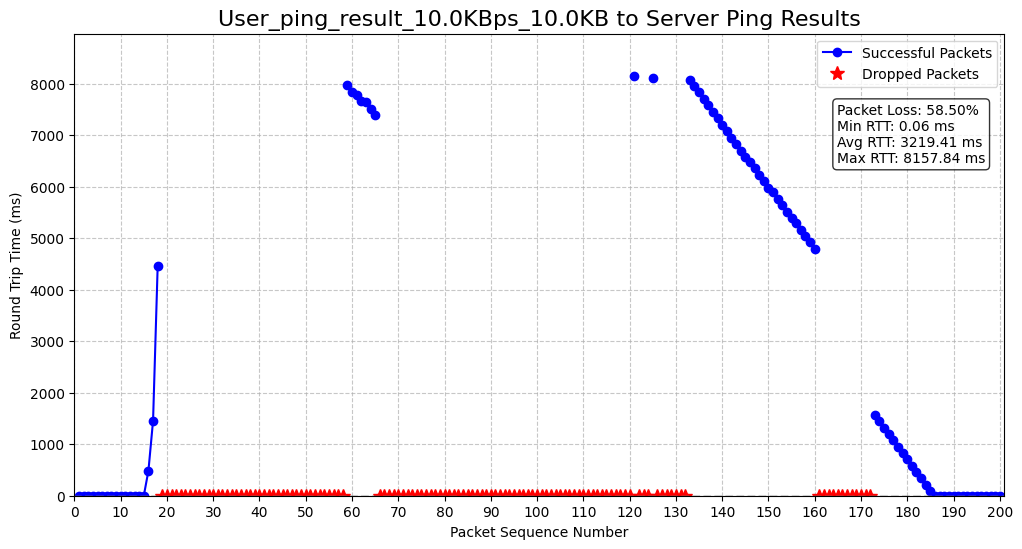

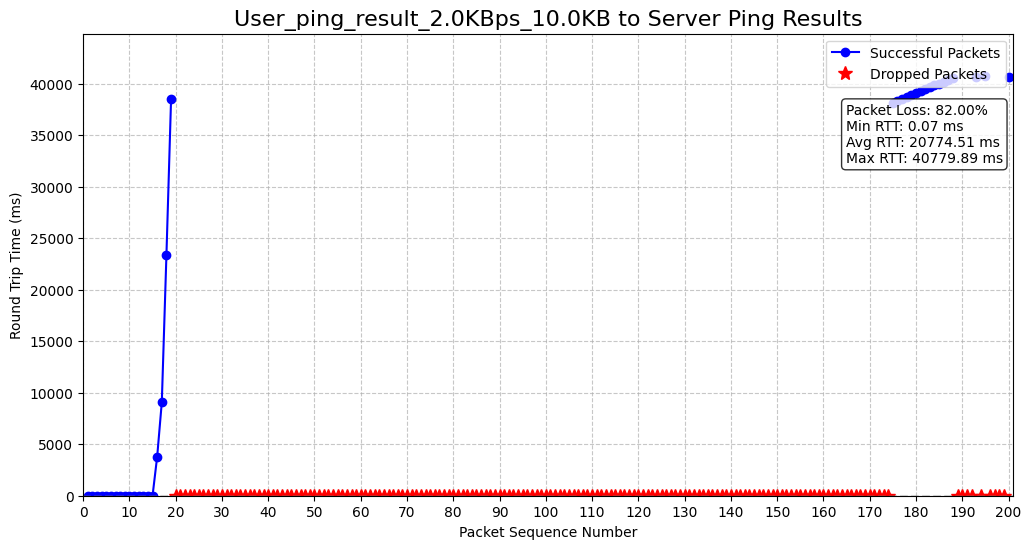

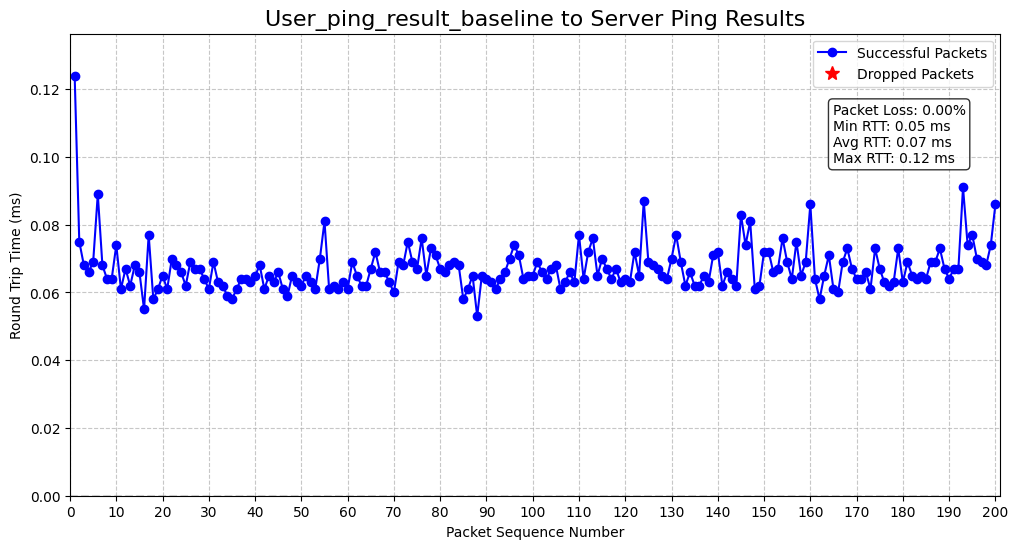

In [13]:
for user in user_info:
    plot_ping_data(user_info[user], f"{user} to Server Ping Results")

### 6. Cleanup Resources

In [15]:
# Delete Output Files
try:
    #To delete the output files change "CLEAN" to "True", to prevent accidental deletion
    CLEAN=True
    if (CLEAN):
        bot_dir = Path("./demo_bot_results")
        user_dir = Path("./demo_user_results")
        # Delete all .txt files in the path
        pattern = f'*.txt'
        for file in bot_dir.glob(pattern):
            if file.is_file():
                file.unlink()
        for file in user_dir.glob(pattern):
            if file.is_file():
                file.unlink()
except Exception as e:
    print(f"Fail: {e}")

# Delete Slice
try:
    #To delete the slice change "CHECK" to "True", this is to prevent accidental slice deletion
    CHECK = False
    if (CHECK):
        slice = fablib.get_slice(slice_name)
        slice.delete()
    else:
        print("Change the Boolean to delete slice")
except Exception as e:
    print(f"Fail: {e}")

Change the Boolean to delete slice
